In [1]:
from pyspark.sql import SparkSession

#
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("FrequentItemsets") \
    .config("spark.master", "local") \
    .config("spark.jars", "F:/UniPrj/Big Data Project/postgresql-42.2.16.jar") \
    .getOrCreate()


In [2]:
jdbc_url = "jdbc:postgresql://localhost:5432/AmazonProducts"
properties = {
    "user": "postgres",
    "password": "root",
    "driver": "org.postgresql.Driver"
}

data_df = spark.read.jdbc(url=jdbc_url, table="furniture_apriori", properties=properties)
data_df.show()

+-----------+--------------+----------+
|customer_id|     review_id|product_id|
+-----------+--------------+----------+
|   24509695|R3VR960AHLFKDV|B004HB5E0E|
|   34731776|R16LGVMFKIUT0G|B0042TNMMS|
|    1272331|R1AIMEEPYHMOE4|B0030MPBZ4|
|   45284262|R1892CCSZWZ9SR|B005G02ESA|
|   18311821| RLB33HJBXHZHU|B00AVUQQGQ|
|   42943632|R1VGTZ94DBAD6A|B00CFY20GQ|
|   43157304|R168KF82ICSOHD|B00FKC48QA|
|   51918480|R20DIYIJ0OCMOG|B00N9IAL9K|
|   14522766| RD46RNVOHNZSC|B001T4XU1C|
|   43054112|R2JDOCETTM3AXS|B002HRFLBC|
|   26622950|R33YMW36IDZ6LE|B006MISZOC|
|   17988940|R30ZGGUHZ04C1S|B008BMGABC|
|   18444952| RS2EZU76IK2BT|B00CO2VH5Y|
|   16937084|R1GJC1BP028XO9|B00LI4RJQ0|
|   23665632|R2VKJPGXXEK5GP|B0046EC1D0|
|    4110125|R17KS83G3KLT97|B00DQQPL36|
|     107621|R3PQL8SR4NEHWL|B003X7RWB2|
|    2415090|R2F5WW7WNO5RRG|B001TJYPJ8|
|   48285966|R3UDJKVWQCFIC9|B000TMHX9A|
|   33228559|R1MLGVJH3J5W6N|B005MZBB2O|
+-----------+--------------+----------+
only showing top 20 rows



In [3]:
from pyspark.sql.functions import collect_list, collect_set

# Remove duplicate product IDs within each transaction
baskets_df = data_df.groupBy("customer_id").agg(
    collect_set("product_id").alias("unique_products")
)

baskets_df.show()

+-----------+--------------------+
|customer_id|     unique_products|
+-----------+--------------------+
|      10339|        [B004H6YP54]|
|      10352|        [B00PC74FQG]|
|      10378|        [B003JUVISQ]|
|      10437|[B00IHFGXFQ, B00H...|
|      10453|        [B001ROR21I]|
|      10813|        [B004LQ1RKQ]|
|      10998|        [B005KUVZRW]|
|      11023|[B00BX2NFY2, B00O...|
|      11067|        [B00BMC54I8]|
|      11094|        [B002VL0DHG]|
|      11111|        [B000NPU1TM]|
|      11163|        [B0035458ZK]|
|      11170|        [B00NPVCNS8]|
|      11180|        [B006L9VANK]|
|      11196|[B005CHAEO8, B00D...|
|      11295|        [B0080KHDHA]|
|      11316|        [B00SX7NP8Q]|
|      11390|        [B003DUJHW6]|
|      11417|        [B005LWS41Y]|
|      11700|        [B00KM2KQTG]|
+-----------+--------------------+
only showing top 20 rows



In [4]:
from pyspark.ml.fpm import FPGrowth

fp_growth = FPGrowth(itemsCol="unique_products", minSupport=0.0001, minConfidence=0.5)
model = fp_growth.fit(baskets_df)


In [5]:
frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

+------------+----+
|       items|freq|
+------------+----+
|[B002V9JIWY]| 343|
|[B002L15NSU]| 102|
|[B001PLOM8Y]| 144|
|[B0002KNLYU]|  81|
|[B00EQG7LVA]| 105|
|[B0042TXBS8]| 328|
|[B0094G36TI]| 143|
|[B0051AQXZK]| 261|
|[B00HETS0PW]| 142|
|[B009WZLOAO]| 249|
|[B005XVV2R6]|  62|
|[B002EAZZVS]| 113|
|[B00G4LP9RI]|  87|
|[B001KZGTNG]| 113|
|[B003XX6JC4]| 168|
|[B0058O8F7I]| 418|
|[B005VAHJOO]|  68|
|[B0038W0LZQ]|  69|
|[B00658O3JU]| 106|
|[B0057POD3S]|  82|
+------------+----+
only showing top 20 rows



In [6]:
import pandas as pd

# Convert frequent itemsets DataFrame to Pandas for easier manipulation
frequent_itemsets_df = frequent_itemsets.toPandas()

# Explode the 'items' column to separate rows for each item
frequent_itemsets_df = frequent_itemsets_df.explode('items')

# Calculate association rules based on frequent itemsets
association_rules = frequent_itemsets_df.copy()

# Calculate lift and confidence for association rules
association_rules['support'] = association_rules.groupby(['items'])['freq'].transform('sum')
association_rules['confidence'] = association_rules['freq'] / association_rules['support']
association_rules['lift'] = association_rules['confidence'] / association_rules.groupby(['items'])['confidence'].transform('sum')

# Filter association rules based on your desired thresholds (e.g., minConfidence, minLift)
min_confidence_threshold = 0.5
min_lift_threshold = 1.0

final_association_rules = association_rules[
    (association_rules['confidence'] >= min_confidence_threshold) &
    (association_rules['lift'] >= min_lift_threshold)
]

# Display the filtered association rules
final_association_rules = final_association_rules[['items', 'confidence', 'lift']]
final_association_rules.rename(columns={'items': 'Itemset', 'confidence': 'Confidence', 'lift': 'Lift'}, inplace=True)
final_association_rules.reset_index(drop=True, inplace=True)
print("Association Rules:")
print(final_association_rules)


Association Rules:
         Itemset  Confidence  Lift
0     B002V9JIWY         1.0   1.0
1     B002L15NSU         1.0   1.0
2     B001PLOM8Y         1.0   1.0
3     B0002KNLYU         1.0   1.0
4     B00EQG7LVA         1.0   1.0
...          ...         ...   ...
1789  B004LQ1RQU         1.0   1.0
1790  B004KFZ5RO         1.0   1.0
1791  B00A7X4M1S         1.0   1.0
1792  B00C1873JU         1.0   1.0
1793  B000NPOQE8         1.0   1.0

[1794 rows x 3 columns]


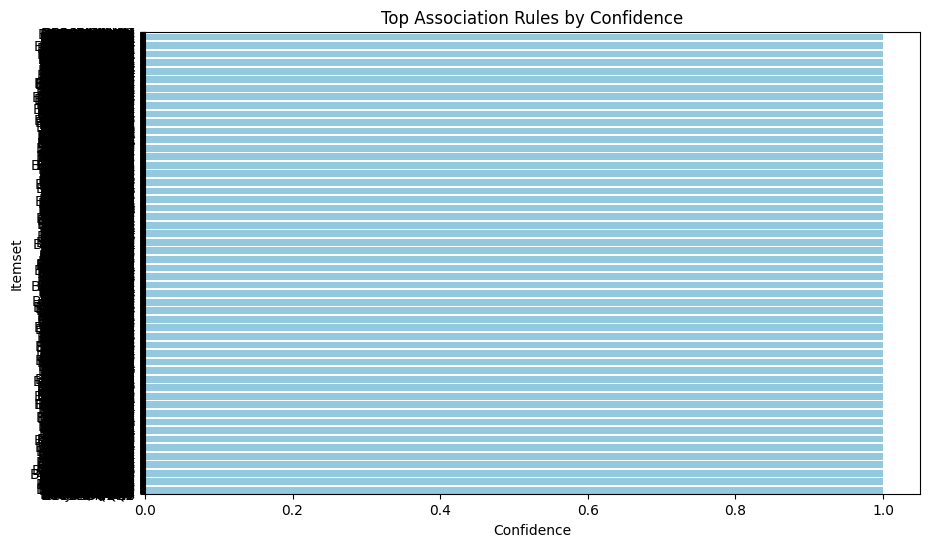

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the final_association_rules DataFrame from the previous code

# Sort association rules by confidence in descending order
sorted_rules = final_association_rules.sort_values(by='Confidence', ascending=False)

# Create a horizontal bar chart for the top association rules
plt.figure(figsize=(10, 6))
sns.barplot(x='Confidence', y='Itemset', data=sorted_rules, color='skyblue')
plt.xlabel('Confidence')
plt.ylabel('Itemset')
plt.title('Top Association Rules by Confidence')
plt.show()


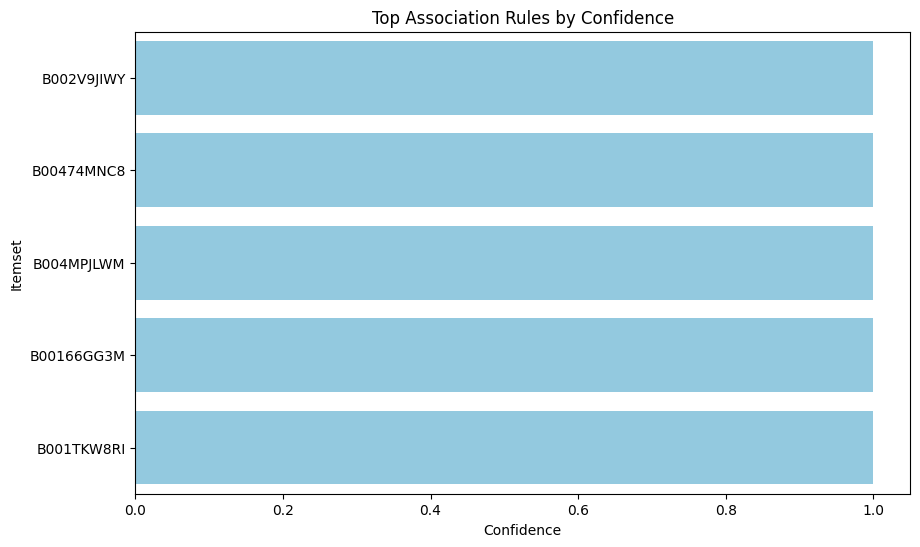


Top Frequent Itemsets with Support:
           items  freq
1803  B006MIUM20  2650
1065  B004LQ1RJ2  1774
414   B003CT37L0  1629
1501  B002PCS0O4  1391
856   B001FB5LE8  1339

Summary Report:

Frequent Itemsets:
  Number of Itemsets: 1808
  Top Itemsets:
        items  freq
0  B002V9JIWY   343
1  B002L15NSU   102
2  B001PLOM8Y   144
3  B0002KNLYU    81
4  B00EQG7LVA   105

Association Rules:
  Number of Rules: 1794
  Top Rules by Confidence:
      Itemset  Confidence  Lift
0  B002V9JIWY         1.0   1.0
1  B002L15NSU         1.0   1.0
2  B001PLOM8Y         1.0   1.0
3  B0002KNLYU         1.0   1.0
4  B00EQG7LVA         1.0   1.0


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the final_association_rules and frequent_itemsets_df DataFrames

# Summary Report
summary_report = {
    "Frequent Itemsets": {
        "Number of Itemsets": len(frequent_itemsets_df),
        "Top Itemsets": frequent_itemsets_df[['items', 'freq']].head(),
    },
    "Association Rules": {
        "Number of Rules": len(final_association_rules),
        "Top Rules by Confidence": final_association_rules[['Itemset', 'Confidence', 'Lift']].head(),
    },
}

# Visualization: Bar chart for top association rules by confidence
plt.figure(figsize=(10, 6))
sns.barplot(x='Confidence', y='Itemset', data=sorted_rules.head(), color='skyblue')
plt.xlabel('Confidence')
plt.ylabel('Itemset')
plt.title('Top Association Rules by Confidence')
plt.show()

# Sort frequent itemsets by support in descending order
sorted_itemsets = frequent_itemsets_df.sort_values(by='freq', ascending=False)

# Display the top frequent itemsets and their support values
print("\nTop Frequent Itemsets with Support:")
print(sorted_itemsets[['items', 'freq']].head())

# Print the summary report
print("\nSummary Report:")
for section, info in summary_report.items():
    print(f"\n{section}:")
    for key, value in info.items():
        if isinstance(value, pd.DataFrame):
            print(f"  {key}:")
            print(value)
        else:
            print(f"  {key}: {value}")
